## Introduction
League of legends is an online game in which two teams composed of five players each battles one another. The goal of the game is to destroy a structure situated in the enemy base and therefore there's no possibility of a draw. Games usually last about 25 to 30 minutes and during that time there are a series of events which can change the balance between the two teams: kills, towers destroyed, dragon taken and so on.

The aim of this project is to analyze, using a bayesian network, how the differents stats taken at the 10 minute mark of a game influence the final win.



In [190]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

In [191]:
model = BayesianNetwork([
    ("killsDiff", "blueGoldDiff"),
    ("minionsDiff", "blueGoldDiff"),
    ("minionsDiff", "blueExperienceDiff"),
    ("towersDiff", "blueGoldDiff"),
    ("towersDiff", "blueWins"),
    ("blueHeralds", "towersDiff"),
    ("redHeralds", "towersDiff"),
    ("dragonsDiff", "blueWins"),
    ("blueExperienceDiff", "blueWins"),
    ("blueGoldDiff", "blueWins")
])

## Dataset
First we load and preprocess the dataset.
The feature of the dataset are:
 1. blueWins: **1** blue teams wins **0** red team wins, there is no draw
 2. goldDiff: gold difference between the two teams. It is measure of how much a team is in advantage
 3. expDiff: experience difference between the two teams. Another measure of how much a team is in advantage
 4. killsDiff: compute as "bluesKills" - "blueDeaths", is the difference between the kills and the deaths of the blue team
 5. minionsDiff: computed as "blueTotalMinionsKilled" - "redTotalMinionsKilled", is the difference between the minions killed by the two teams
 6. towersDiff: computed as "blueTowersDestroyed" - "redTowersDestroyed". Towers are fortifications which defends the teams. The destruction of the towers is crucial to have an advantage
 7. dragonsDiff: computed as "blueDragons" - "redDragons". Dragons are enemies scattered in the map. Killing a dragon gives to the team additional stats.
 8. blueHeralds: Herald are enemies scattered in the map. Killing a Herald gives to the team a friendly minion which is very effective against the enemies tower.
 9. redHeralds: same as above.

In [192]:
import pandas as pd
import numpy as np
def create_dataset(path="high_diamond_ranked_10min.csv"):
    columns = ["blueWins", "blueGoldDiff", "blueExperienceDiff", "blueHeralds", "redHeralds"]
    data = pd.read_csv(path)
    dataset = data.loc[:, columns]
    dataset["killsDiff"] = data.apply(lambda row: row["blueKills"]-row["redKills"], axis=1)
    dataset["minionsDiff"] = data.apply(lambda row: row["blueTotalMinionsKilled"]-row["redTotalMinionsKilled"], axis=1)
    dataset["dragonsDiff"] = data.apply(lambda row: row["blueDragons"]-row["redDragons"], axis=1)
    dataset["towersDiff"] = data.apply(lambda row: row["blueTowersDestroyed"]-row["redTowersDestroyed"], axis=1)
    return dataset

In [193]:
def discretize(dataset):
    negative_neutral_positive = ["Negative", "Neutral", "Positive"]
    negative_neutral_positive_aug = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

    dataset["minionsDiff"] = pd.cut(dataset["minionsDiff"], bins=[-np.inf, -15, +15, np.inf], labels=negative_neutral_positive, include_lowest = True)
    dataset["dragonsDiff"] = pd.cut(dataset["dragonsDiff"], bins=[-np.inf, -1, 0, np.inf], labels=negative_neutral_positive, include_lowest = True)
    dataset["towersDiff"] = pd.cut(dataset["towersDiff"], bins=[-np.inf, -1, 0, np.inf], labels=negative_neutral_positive, include_lowest = True)
    
    
    dataset["blueGoldDiff"] = pd.cut(dataset["blueGoldDiff"], bins=[-np.inf, -2500, -1000, 1000, 2500, np.inf], labels=negative_neutral_positive_aug, include_lowest = True)
    dataset["blueExperienceDiff"] = pd.cut(dataset["blueExperienceDiff"], bins=[-np.inf,-1250,-500, 500, 1250, np.inf], labels=negative_neutral_positive_aug, include_lowest = True)
    dataset["killsDiff"] = pd.cut(dataset["killsDiff"], bins=[-np.inf,-4, -2, 2, 4, np.inf], labels=negative_neutral_positive_aug, include_lowest = True)



    dataset["blueHeralds"] = pd.cut(dataset["blueHeralds"], bins=[-1,0,np.inf], labels=["Low", "High"], include_lowest = True)
    dataset["redHeralds"] = pd.cut(dataset["redHeralds"], bins=[-1,0,np.inf], labels=["Low", "High"], include_lowest = True)

    return dataset

In [194]:
dataset = create_dataset()
dataset = discretize(dataset)
dataset.head()

for column in dataset:
    print(pd.value_counts(dataset[column]))



0    4949
1    4930
Name: blueWins, dtype: int64
Neutral          3248
Positive         1865
Negative         1819
Very Positive    1476
Very Negative    1471
Name: blueGoldDiff, dtype: int64
Very Negative    2544
Very Positive    2411
Neutral          2110
Negative         1442
Positive         1372
Name: blueExperienceDiff, dtype: int64
Low     8022
High    1857
Name: blueHeralds, dtype: int64
Low     8298
High    1581
Name: redHeralds, dtype: int64
Neutral          3671
Very Negative    1941
Negative         1550
Very Positive    1406
Positive         1311
Name: killsDiff, dtype: int64
Neutral     3769
Negative    3189
Positive    2921
Name: minionsDiff, dtype: int64
Negative    4081
Positive    3576
Neutral     2222
Name: dragonsDiff, dtype: int64
Neutral     9064
Positive     441
Negative     374
Name: towersDiff, dtype: int64


## Model Structure Optimization 


In [195]:
from pgmpy.estimators import HillClimbSearch, K2Score, ExhaustiveSearch, BicScore, BDeuScore, BDsScore, MmhcEstimator

estimator = HillClimbSearch(dataset)

black_list = [('blueWins', node) for node in dataset.columns[:-1]]
optimized_model = estimator.estimate(scoring_method=BDsScore(dataset), black_list=black_list)
optimized_model = BayesianNetwork(optimized_model)

  0%|          | 16/1000000 [00:01<20:21:21, 13.65it/s]


# Parameter Estimation


In [196]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator

model.cpds = []

model.fit(data=dataset,
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10,
            complete_samples_only=False,
)

optimized_model.fit(data=dataset,
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10,
            complete_samples_only=False,
)

#pd.options.display.max_columns = 2000

print(f"Check model: {model.check_model()=}")
print(f"Check model: {optimized_model.check_model()=}")



for cpd in model.get_cpds():
    #print(f"CPT of {cpd.variable}")
    #print(cpd)
    pass


Check model: model.check_model()=True
Check model: optimized_model.check_model()=True


# Inference

In [197]:
from pgmpy.inference import VariableElimination

def queries(model):
    model_inference = VariableElimination(model)

    def print_query(target, evidence):
        value = model_inference.query(target, evidence)
        print(f"P({', '.join(target)} | {', '.join([f'{k}={v}' for (k, v) in evidence.items()])}) = \n{value}\n")

    #blueWins, blueGoldDiff, towersDiff, killsDiff, blueExperienceDiff, blueHeralds, redHeralds, minionsDiff

    queries = [
        (["blueWins"], {"blueGoldDiff": "Positive"}),
        #(["blueWins"], {"blueGoldDiff": "Very Positive"}),
        (["blueWins"], {"blueGoldDiff": "Positive", "towersDiff": "Positive"}),
        #(["blueWins"], {"blueGoldDiff": "Positive", "towersDiff": "Negative"}),
        (["blueWins"], {"blueGoldDiff": "Very Negative", "towersDiff": "Positive", "dragonsDiff": "Positive", "blueExperienceDiff": "Positive"}),
        (["blueGoldDiff"], {"blueWins": 1}),

        # Active v-structure
        (["blueExperienceDiff"], {"dragonsDiff": "Positive", "blueWins": 0}),
        (["killsDiff"], {"blueWins": 1}),

        # Active v-structure long
        (["killsDiff"], {"blueHeralds": "High", "blueGoldDiff": "Positive"}),
        (["killsDiff"], {"blueHeralds": "Low", "blueGoldDiff": "Positive"}),

        # Non active v-structure
        (["killsDiff"], {"blueHeralds": "High", "blueGoldDiff": "Positive", "towersDiff": "Positive"}),
        (["killsDiff"], {"blueHeralds": "Low", "blueGoldDiff": "Positive", "towersDiff": "Positive"}),
    ]

    
    for query in queries:
        print_query(*query)

queries(model)

P(blueWins | blueGoldDiff=Positive) = 
+-------------+-----------------+
| blueWins    |   phi(blueWins) |
+=============+=================+
| blueWins(0) |          0.3425 |
+-------------+-----------------+
| blueWins(1) |          0.6575 |
+-------------+-----------------+

P(blueWins | blueGoldDiff=Positive, towersDiff=Positive) = 
+-------------+-----------------+
| blueWins    |   phi(blueWins) |
+=============+=================+
| blueWins(0) |          0.3649 |
+-------------+-----------------+
| blueWins(1) |          0.6351 |
+-------------+-----------------+

P(blueWins | blueGoldDiff=Very Negative, towersDiff=Positive, dragonsDiff=Positive, blueExperienceDiff=Positive) = 
+-------------+-----------------+
| blueWins    |   phi(blueWins) |
+=============+=================+
| blueWins(0) |          0.5000 |
+-------------+-----------------+
| blueWins(1) |          0.5000 |
+-------------+-----------------+

P(blueGoldDiff | blueWins=1) = 
+-----------------------------+-----

In [198]:
def active_trails_of(query, evidence):
    active = model.active_trail_nodes(query, observed=evidence).get(query)
    active.remove(query)
    if active:
        if evidence:
            print(f'Active trails between \'{query}\' and {active} given the evidence {set(evidence)}.')
        else:
            print(f'Active trails between \'{query}\' and {active} given no evidence.')
    else:
        print(f'No active trails for \'{query}\' given the evidence {set(evidence)}.')

active_trails_of("blueGoldDiff", ["blueWins", "towersDiff"])



def markov_blanket_of(node):
    print(f'Markov blanket of \'{node}\' is {set(model.get_markov_blanket(node))}')

markov_blanket_of(node='blueGoldDiff')

Active trails between 'blueGoldDiff' and {'killsDiff', 'dragonsDiff', 'minionsDiff', 'blueExperienceDiff'} given the evidence {'blueWins', 'towersDiff'}.
Markov blanket of 'blueGoldDiff' is {'towersDiff', 'killsDiff', 'dragonsDiff', 'blueWins', 'minionsDiff', 'blueExperienceDiff'}


## Model graph

In [199]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import pydot
import matplotlib.pyplot as plt

def draw_graph(model):
    pos = graphviz_layout(model, prog="dot")
    plt.figure(figsize=(10, 5))
    nx.draw(model, with_labels=True, pos=pos, node_size=3000, node_color="green")
    plt.savefig('model.png')
    plt.show()



## Results

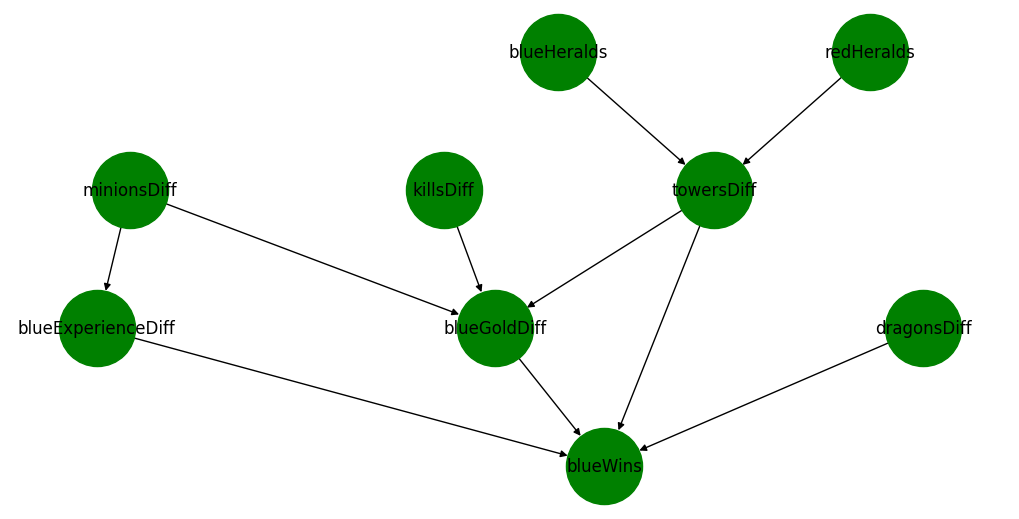

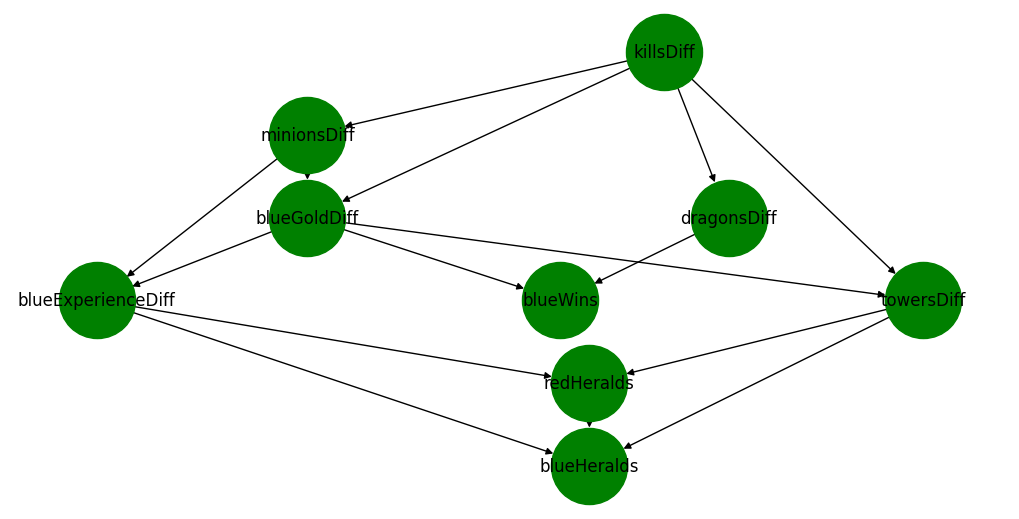

In [200]:
draw_graph(model)
draw_graph(optimized_model)


In [201]:
print("Hand made model:\n")
queries(model)
print("Optimized model:\n")
queries(optimized_model)

Hand made model:

P(blueWins | blueGoldDiff=Positive) = 
+-------------+-----------------+
| blueWins    |   phi(blueWins) |
+=============+=================+
| blueWins(0) |          0.3425 |
+-------------+-----------------+
| blueWins(1) |          0.6575 |
+-------------+-----------------+

P(blueWins | blueGoldDiff=Positive, towersDiff=Positive) = 
+-------------+-----------------+
| blueWins    |   phi(blueWins) |
+=============+=================+
| blueWins(0) |          0.3649 |
+-------------+-----------------+
| blueWins(1) |          0.6351 |
+-------------+-----------------+

P(blueWins | blueGoldDiff=Very Negative, towersDiff=Positive, dragonsDiff=Positive, blueExperienceDiff=Positive) = 
+-------------+-----------------+
| blueWins    |   phi(blueWins) |
+=============+=================+
| blueWins(0) |          0.5000 |
+-------------+-----------------+
| blueWins(1) |          0.5000 |
+-------------+-----------------+

P(blueGoldDiff | blueWins=1) = 
+-----------------